In [1]:
import scipy.io
from SimPEG import *
import SimPEG.PF as PF
import matplotlib.patches as patches
%pylab inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    
Populating the interactive namespace from numpy and matplotlib


In [2]:
work_dir = 'C:\\LC\\Private\\dominiquef\\Projects\\4414_Minsim\\Modeling\\VPmg'
meshfile = 'Mesh_20m.msh'
locfile = 'Mag_grid_50m.dat'
modelfile = 'Mesh_20m_Susc\\Randn_Std_model.sus'
nullcell = 'Mesh_20m_Susc\\nullcell.dat'

obsfile = 'Mesh_20m_Susc\\magfor3d.mag'
topofile = 'Mesh_20m_Susc\\ROT_DEM_30m.topo'





In [3]:
mesh = Mesh.TensorMesh.readUBC(work_dir + '\\' + meshfile)
locs = np.loadtxt(work_dir + '\\' + locfile)
model = mesh.readModelUBC(work_dir + '\\' + modelfile)

topo = np.genfromtxt(work_dir + '\\' + topofile,
                                     skip_header=1)

actvmod = mesh.readModelUBC(work_dir + '\\' + nullcell)
actv = np.ones(mesh.nC,dtype=bool)
actv[actvmod==0] = False

srvy = PF.MagneticsDriver.MagneticsDriver_Inv()
srvy.basePath = work_dir
data = srvy.readMagneticsObservations('\\'+obsfile)

locs = data.srcField.rxList[0].locs

In [33]:
# Begin tiling
max_mcell = 2e+5;
min_Olap = 7.5e+2;

# In the x-direction
ntile = 1
Olap  = -1

# Cell size
dx = 20.

lx = np.floor((1500/dx))

while Olap < min_Olap:
# for ii in range(5):
    
    ntile += 1
    
    # Set location of SW corners
    x0 = np.asarray([mesh.vectorNx[0],mesh.vectorNx[-1] - lx*dx])
    
    dx_t = np.round( ( x0[1] - x0[0] ) / ( (ntile-1) * dx) )

    if ntile>2: 
        x1 = np.r_[x0[0],
                   x0[0] + cumsum(np.ones(ntile-2) * dx_t * dx),
                   x0[1]]
    else:
        x1 = np.asarray([x0[0],x0[1]])    
        
    
    x2 = x1 + lx*dx;

#     y1 = np.ones(x1.shape[0])*np.min(locs[:,1]);
#     y2 = np.ones(x1.shape[0])*(np.min(locs[:,1]) + lx*dx);
    
    Olap = x1[0] + lx*dx - x1[1];


# Save x-corner location
xtile = np.c_[x1,x2]



# In the Y-direction
ntile = 1
Olap  = -1

# Cell size

while Olap < min_Olap:
# for ii in range(5):
    
    ntile += 1
    
    # Set location of SW corners
    y0 = np.asarray([mesh.vectorNy[0],mesh.vectorNy[-1] - lx*dx])
    
    dy_t = np.round( ( y0[1] - y0[0] ) / ( (ntile-1) * dx) )

    if ntile>2: 
        y1 = np.r_[y0[0],
                   y0[0] + cumsum(np.ones(ntile-2) * dy_t * dx),
                   y0[1]]
    else:
        y1 = np.asarray([y0[0],y0[1]])    
        
    
    y2 = y1 + lx*dx;

#     x1 = np.ones(y1.shape[0])*np.min(locs[:,0]);
#     x2 = np.ones(y1.shape[0])*(np.min(locs[:,0]) + lx*dx);
    
    Olap = y1[0] + lx*dx - y1[1];


# Save x-corner location
ytile = np.c_[y1,y2]


X,Y = np.meshgrid(x1,y1)

x0 = mkvc(X)
y0 = mkvc(Y)

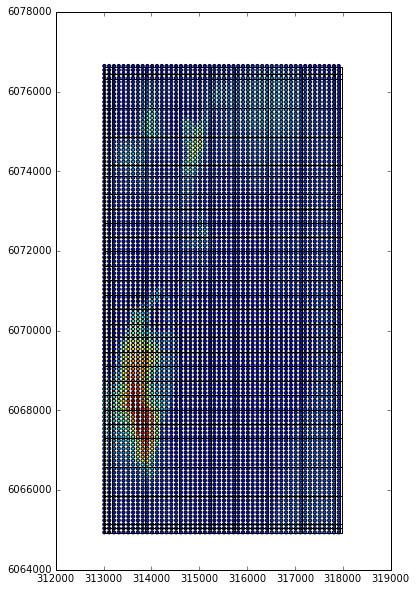

In [36]:
# Loop through the tiles and create meshs
meshes = []
fig, axs = plt.figure(figsize=(6,10)), subplot(111)
axs.scatter(locs[:,0],locs[:,1],c=data.dobs,s=10,edgecolor=None)
#axs.set_aspect('equal')

npad = 5
expf = 1.3

tID = 7

pdis = np.sum(dx*expf**(np.asarray(range(npad))+1))

padf = np.r_[dx*expf**(np.asarray(range(npad))+1),200*1**np.asarray(range(npad))]
padb = padf[::-1]
    
for ii in range(len(mkvc(X[:]))):
    
    # Add paddings but only keep cells within the VOI
    W_pad = (x0[ii] - np.cumsum(padb)) > mesh.vectorNx[0]
    E_pad = (x0[ii] + lx*dx + np.cumsum(padf)) < mesh.vectorNx[-1]
    
    S_pad = (y0[ii] - np.cumsum(padb)) > mesh.vectorNy[0]
    N_pad = (y0[ii] + lx*dx + np.cumsum(padf)) < mesh.vectorNy[-1]
    
    hx = np.r_[padb[W_pad], np.ones(lx)*dx, padf[E_pad]]
    hy = np.r_[padb[S_pad], np.ones(lx)*dx, padf[N_pad]]
    hz = [(50,30,1),(20,20,1),(10,10,1),(5,30,1)]
    
    mtemp = Mesh.TensorMesh([hx,hy,hz])
    
    mtemp._x0 = [x0[ii]-np.sum(padb[W_pad]), y0[ii]-np.sum(padb[S_pad]), mesh.x0[2]+np.sum(mesh.hz)-np.sum(mtemp.hz)]
    
    meshes.append(mtemp)
    
    axs.add_patch(
    patches.Rectangle(
        (mtemp.x0[0],mtemp.x0[1]),   # (x,y)
        np.sum(mtemp.hx),          # width
        np.sum(mtemp.hy), fill = False          # height
    )
)

In [6]:
len(meshes)

21

In [7]:
# actv = Utils.surface2ind_topo(mesh, topo, 'N')
# actv = np.asarray([inds for inds, elem in enumerate(actv, 1)
#                   if elem], dtype=int) - 1


actv2 = Utils.surface2ind_topo(meshes[tID], topo, 'N')
# actv2 = np.asarray([inds for inds, elem in enumerate(actv2, 1)
#                   if elem], dtype=int) - 1

P = Maps.Mesh2MeshTopo([mesh,meshes[tID]],[actv,actv2],nIterpPts = 12)

bb = P*(model[actv])
m = np.ones(meshes[tID].nC)*-100
m[actv2] = bb



812547


C:\Users\dominiquef.MIRAGEOSCIENCE\Documents\GIT\SimPEG\simpeg\SimPEG\Maps.py:176: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  not self.shape[1] == '*' and not self.shape[1] == val.shape[0]


In [8]:
Mesh.TensorMesh.writeUBC(meshes[tID],work_dir +'\\MeshTile1.msh')
Mesh.TensorMesh.writeModelUBC(meshes[tID],work_dir +'\\MeshTile1.sus',m)

In [29]:


# Grab the data
indx = (locs[:,0] > x0[tID]) & (locs[:,0] < x0[tID]+lx*dx) & (locs[:,1] > y0[tID]) & (locs[:,1] < y0[tID]+lx*dx)

subrx = PF.BaseMag.RxObs(np.c_[locs[indx,0], locs[indx,1], locs[indx,2]])
    
srcParam = np.asarray((60000,79,31))
srcField = PF.BaseMag.SrcField([subrx],param=srcParam)
survey = PF.BaseMag.LinearSurvey(srcField)
    
# Create PF problem
nC = int(np.sum(actv2))
idenMap = Maps.IdentityMap(nP = nC)
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv2, -100)

prob = PF.Magnetics.MagneticIntegral(meshes[tID], chiMap = idenMap, actInd = actv2, forwardOnly = True)

survey.pair(prob)

d = prob.fields(m[actv2])

Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



In [30]:
meshes[tID].nC

1188000

Observation file saved to: C:\LC\Private\dominiquef\Projects\4414_Minsim\Modeling\VPmg\FWR_tile7.obs


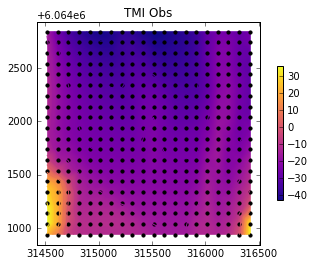

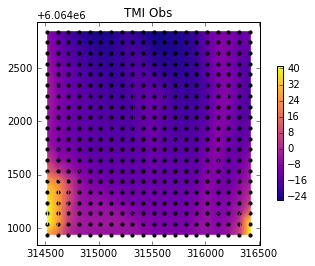

In [41]:

p = PF.Magnetics.plot_obs_2D(locs[indx,:],data.dobs[indx])
p = PF.Magnetics.plot_obs_2D(locs[indx,:],d)

survey.dobs=d
survey.std=d**0.

PF.Magnetics.writeUBCobs(work_dir +'\\FWR_tile'+ str(tID)+'.obs',survey,d)


In [39]:
aa = {'DC':np.zeros(3),'MAG':np.zeros(3)}


In [46]:
dtype = ['MAG','DC','GRAV']
range(len(dtype))

[0, 1, 2]

In [47]:
for dID in dtype:
    print(dID)


MAG
DC
GRAV
